In [12]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json # import json for formatting data
import os # and os for saving
import boto3
import sagemaker
from sagemaker import get_execution_role
import pickle

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

In [13]:
features_file = 'data/features.csv'
features_df = pd.read_csv(features_file)

stores_file = 'data/stores.csv'
stores_df = pd.read_csv(stores_file)

test_file = 'data/test.csv'
test_df = pd.read_csv(test_file)

In [100]:
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Week'] = train_df.Date.apply(lambda x: x.weekofyear)
train_df['Year'] = train_df.Date.apply(lambda x: x.year)
train_df = train_df.drop(['Date'], axis=1)

train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# Create a column with Store and Dept number as a key
# We add '00' to avoid misunderstanding
# train_df['StoreDept'] = train_df['Store'].map(str) + str('00') + train_df['Dept'].map(str)

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year
0,1,1,24924.50,1,5,2010
1,1,1,46039.49,5,6,2010
2,1,1,41595.55,1,7,2010
3,1,1,19403.54,1,8,2010
4,1,1,21827.90,1,9,2010


In [101]:
train_df2 = train_df.copy()
train_df2 = train_df2[train_df2['Store']<3]
train_df2['Last_Week_Sales'] = train_df2.groupby(['Store','Dept'])['Weekly_Sales'].shift()
train_df2['Last_Week_Diff'] = train_df2.groupby(['Store','Dept'])['Last_Week_Sales'].diff()
train_df2 = train_df2.dropna()
train_df2.head()
#len(train_df2)

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year,Last_Week_Sales,Last_Week_Diff
2,1,1,41595.55,1,7,2010,46039.49,21114.99
3,1,1,19403.54,1,8,2010,41595.55,-4443.94
4,1,1,21827.90,1,9,2010,19403.54,-22192.01
5,1,1,21043.39,1,10,2010,21827.90,2424.36
6,1,1,22136.64,1,11,2010,21043.39,-784.51


In [102]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

## RMSLE / Store/dept / Last Week Sales

In [103]:
mean_error = []
week = 8

train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

val = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

for store in train_df2['Store'].unique():
    for dept in train_df2['Dept'].unique():
        # Compute and print RMSLE for each series
        data_df = val[(val.Store == store)&(val.Dept == dept)]

        p = data_df['Last_Week_Sales'].values
        
        if len(p)>0:
            error = rmsle(data_df['Weekly_Sales'].values, p)
            print('Store %d - Dept %d - Error %.5f' % (store, dept, error))
            mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Store 1 - Dept 1 - Error 0.25932
Store 1 - Dept 2 - Error 0.06923
Store 1 - Dept 3 - Error 0.24245
Store 1 - Dept 4 - Error 0.08045
Store 1 - Dept 5 - Error 0.18795
Store 1 - Dept 6 - Error 1.91116
Store 1 - Dept 7 - Error 0.16584
Store 1 - Dept 8 - Error 0.07146
Store 1 - Dept 9 - Error 0.18285
Store 1 - Dept 10 - Error 0.10647
Store 1 - Dept 11 - Error 0.19363
Store 1 - Dept 12 - Error 0.14294
Store 1 - Dept 13 - Error 0.07680
Store 1 - Dept 14 - Error 0.12789
Store 1 - Dept 16 - Error 0.20074
Store 1 - Dept 17 - Error 0.14428
Store 1 - Dept 18 - Error 1.63663
Store 1 - Dept 19 - Error 0.32566
Store 1 - Dept 20 - Error 0.21197
Store 1 - Dept 21 - Error 0.12054
Store 1 - Dept 22 - Error 0.17491
Store 1 - Dept 23 - Error 0.14450
Store 1 - Dept 24 - Error 0.27757
Store 1 - Dept 25 - Error 0.16023
Store 1 - Dept 26 - Error 0.19615
Store 1 - Dept 27 - Error 0.19059
Store 1 - Dept 28 - Error 0.21083
Store 1 - Dept 29 - Error 0.13915
Store 1 - Dept 30 - Error 0.19779
Store 1 - Dept 31 - Err

## RMSLE / week / Last Week Sales

In [104]:
mean_error = []
for week in range(8,43):

    train2010 = train_df2[train_df2['Year'] == 2010]
    train2011 = train_df2[train_df2['Year'] == 2011]
    train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
    train = train2010.append(train2011).append(train2012)
    
    val = train_df2[(train_df2['Week'] == week) & (train_df2['Year'] == 2012)]

    p = val['Last_Week_Sales'].values

    error = rmsle(val['Weekly_Sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 8 - Error 0.63046
Week 9 - Error 0.51319


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 10 - Error 0.35642
Week 11 - Error 0.38096


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 12 - Error 0.67254
Week 13 - Error 0.66868


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 14 - Error 0.28252
Week 15 - Error 0.40351


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 16 - Error 0.64187
Week 17 - Error 0.62446


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 18 - Error 0.39527
Week 19 - Error 0.28579


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 20 - Error 0.19541
Week 21 - Error 0.22957


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 22 - Error 0.24877
Week 23 - Error 0.54641


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 24 - Error 0.30732
Week 25 - Error 0.29223


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 26 - Error 0.34906
Week 27 - Error 0.18541


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 28 - Error 0.40853
Week 29 - Error 0.45685


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 30 - Error 0.22024
Week 31 - Error 0.60025


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 32 - Error 0.80508
Week 33 - Error 0.75363


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 34 - Error 0.42502
Week 35 - Error 0.38903


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 36 - Error 0.49037
Week 37 - Error 0.47227


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 38 - Error 0.29868
Week 39 - Error 0.29491


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 40 - Error 0.81705
Week 41 - Error 0.37607
Week 42 - Error 0.33158
Mean Error = 0.43856


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## WMAE / Store/dept / Last Week Sales

In [105]:
total_sum_weights=[]
total_sum_weighted_error=[]

for store in train_df2['Store'].unique():
    for dept in train_df2['Dept'].unique():
        # Compute and print WMAE for each series
        data_df = train_df2[(train_df2.Store == store)&(train_df2.Dept == dept)]
        data_df['weighted_error']=data_df['IsHoliday']*abs(data_df['Weekly_Sales']-data_df['Last_Week_Sales'])
        sum_weights = data_df.IsHoliday.sum()
        sum_weighted_error = data_df.weighted_error.sum()
        wmae = (1/sum_weights) * sum_weighted_error
        
        if str(wmae) != 'nan':
            print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
            total_sum_weights.append(sum_weights)
            total_sum_weighted_error.append(sum_weighted_error)
        
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Weighted mean absolute error (WMAE) for Store 1 Dept 1 = 6022.671525423728
Weighted mean absolute error (WMAE) for Store 1 Dept 2 = 3945.4836158192097
Weighted mean absolute error (WMAE) for Store 1 Dept 3 = 3364.568587570622
Weighted mean absolute error (WMAE) for Store 1 Dept 4 = 3196.318926553672
Weighted mean absolute error (WMAE) for Store 1 Dept 5 = 8888.024689265538
Weighted mean absolute error (WMAE) for Store 1 Dept 6 = 3242.9519774011305
Weighted mean absolute error (WMAE) for Store 1 Dept 7 = 13069.187005649716
Weighted mean absolute error (WMAE) for Store 1 Dept 8 = 2266.1390960451977
Weighted mean absolute error (WMAE) for Store 1 Dept 9 = 6027.056553672316
Weighted mean absolute error (WMAE) for Store 1 Dept 10 = 2784.8285875706215
Weighted mean absolute error (WMAE) for Store 1 Dept 11 = 4035.5635028248594
Weighted mean absolute error (WMAE) for Store 1 Dept 12 = 1134.10802259887
Weighted mean absolute error (WMAE) for Store 1 Dept 13 = 2412.1637288135607
Weighted mean a

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in long_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


Weighted mean absolute error (WMAE) for Store 2 Dept 4 = 3835.5441242937854
Weighted mean absolute error (WMAE) for Store 2 Dept 5 = 13714.555875706214
Weighted mean absolute error (WMAE) for Store 2 Dept 6 = 3921.5690395480224
Weighted mean absolute error (WMAE) for Store 2 Dept 7 = 21776.137570621468
Weighted mean absolute error (WMAE) for Store 2 Dept 8 = 3447.4859322033894
Weighted mean absolute error (WMAE) for Store 2 Dept 9 = 9183.121807909605
Weighted mean absolute error (WMAE) for Store 2 Dept 10 = 3649.9128813559328
Weighted mean absolute error (WMAE) for Store 2 Dept 11 = 4227.749152542372
Weighted mean absolute error (WMAE) for Store 2 Dept 12 = 690.2178531073446
Weighted mean absolute error (WMAE) for Store 2 Dept 13 = 2540.33593220339
Weighted mean absolute error (WMAE) for Store 2 Dept 14 = 6905.82163841808
Weighted mean absolute error (WMAE) for Store 2 Dept 16 = 4143.5599999999995
Weighted mean absolute error (WMAE) for Store 2 Dept 17 = 2600.222429378531
Weighted mean

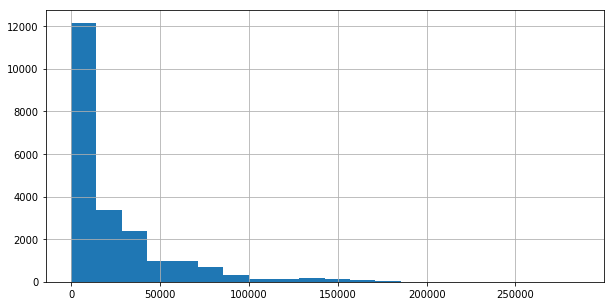

In [18]:
train_df2['Weekly_Sales'].hist(bins=20, figsize=(10,5))

In [96]:
train_df2.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year
2,1,1,41595.55,1,7,2010
3,1,1,19403.54,1,8,2010
4,1,1,21827.90,1,9,2010
5,1,1,21043.39,1,10,2010
6,1,1,22136.64,1,11,2010


## RMSLE / Store/dept / Random Forest

In [109]:
mean_error = []
week = 8

# train_df2 = train_df2.drop(['Last_Week_Sales','Last_Week_Diff'], axis=1)

train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

val = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

for store in train_df2['Store'].unique():
    for dept in train_df2['Dept'].unique():
        
        train_sd = train[(train.Store == store)&(train.Dept == dept)]
        val_sd = val[(val.Store == store)&(val.Dept == dept)]
  
        xtr, xts = train_sd.drop(['Weekly_Sales'], axis=1), val_sd.drop(['Weekly_Sales'], axis=1)
        ytr, yts = train_sd['Weekly_Sales'].values, val_sd['Weekly_Sales'].values

        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        if len(xtr)>35:
            mdl.fit(xtr, ytr)
        
            if len(xts)>35:
                p = mdl.predict(xts)

                if len(p)>0:
                    error = rmsle(yts, p)
                    print('Store %d - Dept %d - Error %.5f' % (store, dept, error))
                    mean_error.append(error)
                
print('Mean Error = %.5f' % np.mean(mean_error))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Store 1 - Dept 1 - Error 0.14986
Store 1 - Dept 2 - Error 0.04491
Store 1 - Dept 3 - Error 0.12888
Store 1 - Dept 4 - Error 0.07398
Store 1 - Dept 5 - Error 0.17700
Store 1 - Dept 6 - Error 1.38767
Store 1 - Dept 7 - Error 0.16937
Store 1 - Dept 8 - Error 0.09792
Store 1 - Dept 9 - Error 0.16778
Store 1 - Dept 10 - Error 0.09762
Store 1 - Dept 11 - Error 0.17792
Store 1 - Dept 12 - Error 0.11332
Store 1 - Dept 13 - Error 0.06699
Store 1 - Dept 14 - Error 0.11154
Store 1 - Dept 16 - Error 0.14441
Store 1 - Dept 17 - Error 0.12696
Store 1 - Dept 19 - Error 0.27807
Store 1 - Dept 20 - Error 0.17965
Store 1 - Dept 21 - Error 0.10481
Store 1 - Dept 22 - Error 0.15845
Store 1 - Dept 23 - Error 0.11593
Store 1 - Dept 24 - Error 0.23440
Store 1 - Dept 25 - Error 0.12477
Store 1 - Dept 26 - Error 0.18144
Store 1 - Dept 27 - Error 0.19762
Store 1 - Dept 28 - Error 0.20686
Store 1 - Dept 29 - Error 0.10390
Store 1 - Dept 30 - Error 0.21859
Store 1 - Dept 31 - Error 0.37992
Store 1 - Dept 32 - Err

## WIP / WMAE / Store/dept / Random Forest

In [ ]:
mean_error = []
week = 8

# train_df2 = train_df2.drop(['Last_Week_Sales','Last_Week_Diff'], axis=1)

train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

val = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

for store in train_df2['Store'].unique():
    for dept in train_df2['Dept'].unique():
        
        train_sd = train[(train.Store == store)&(train.Dept == dept)]
        val_sd = val[(val.Store == store)&(val.Dept == dept)]
  
        xtr, xts = train_sd.drop(['Weekly_Sales'], axis=1), val_sd.drop(['Weekly_Sales'], axis=1)
        ytr, yts = train_sd['Weekly_Sales'].values, val_sd['Weekly_Sales'].values

        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        if len(xtr)>35:
            mdl.fit(xtr, ytr)
        
            if len(xts)>35:
                p = mdl.predict(xts)

                if len(p)>0:
                    error = rmsle(yts, p)
                    print('Store %d - Dept %d - Error %.5f' % (store, dept, error))
                    mean_error.append(error)
                
print('Mean Error = %.5f' % np.mean(mean_error))




data_df['weighted_error']=data_df['IsHoliday']*abs(data_df['Weekly_Sales']-data_df['Last_Week_Sales'])
        sum_weights = data_df.IsHoliday.sum()
        sum_weighted_error = data_df.weighted_error.sum()
        wmae = (1/sum_weights) * sum_weighted_error
        
        if str(wmae) != 'nan':
            print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
            total_sum_weights.append(sum_weights)
            total_sum_weighted_error.append(sum_weighted_error)
        
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

In [76]:
mean_error = []
for week in range(8,43):

    train2010 = train_df2[train_df2['Year'] == 2010]
    train2011 = train_df2[train_df2['Year'] == 2011]
    train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
    train = train2010.append(train2011).append(train2012)
    
    val = train_df2[(train_df2['Week'] == week) & (train_df2['Year'] == 2012)]
    

    xtr, xts = train.drop(['Weekly_Sales'], axis=1), val.drop(['Weekly_Sales'], axis=1)
    ytr, yts = train['Weekly_Sales'].values, val['Weekly_Sales'].values

    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 8 - Error 0.60218


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 9 - Error 0.37971


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 10 - Error 0.34465


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 11 - Error 0.29093


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 12 - Error 0.68167


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 13 - Error 0.20401


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 14 - Error 0.34093


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 15 - Error 0.48233


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 16 - Error 0.62174


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 17 - Error 0.69414


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 18 - Error 0.42416


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 19 - Error 0.37150


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 20 - Error 0.29840


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 21 - Error 0.28138


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 22 - Error 0.30186


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 23 - Error 0.41702


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 24 - Error 0.20046


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 25 - Error 0.29387


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 26 - Error 0.51912


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 27 - Error 0.66454


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 28 - Error 0.64420


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 29 - Error 0.61010


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 30 - Error 0.71098


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 31 - Error 0.35417


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 32 - Error 0.84214


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 33 - Error 0.61835


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 34 - Error 0.44968


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 35 - Error 0.39802


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 36 - Error 0.90392


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 37 - Error 0.49368


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 38 - Error 0.22389


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 39 - Error 0.30956


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 40 - Error 0.42446


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 41 - Error 0.38238


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Week 42 - Error 0.26348
Mean Error = 0.45839
